In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Total mask that has modified name: 566
Data loaded from saved files.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 512, 512, 64)         640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 512, 512, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation) 

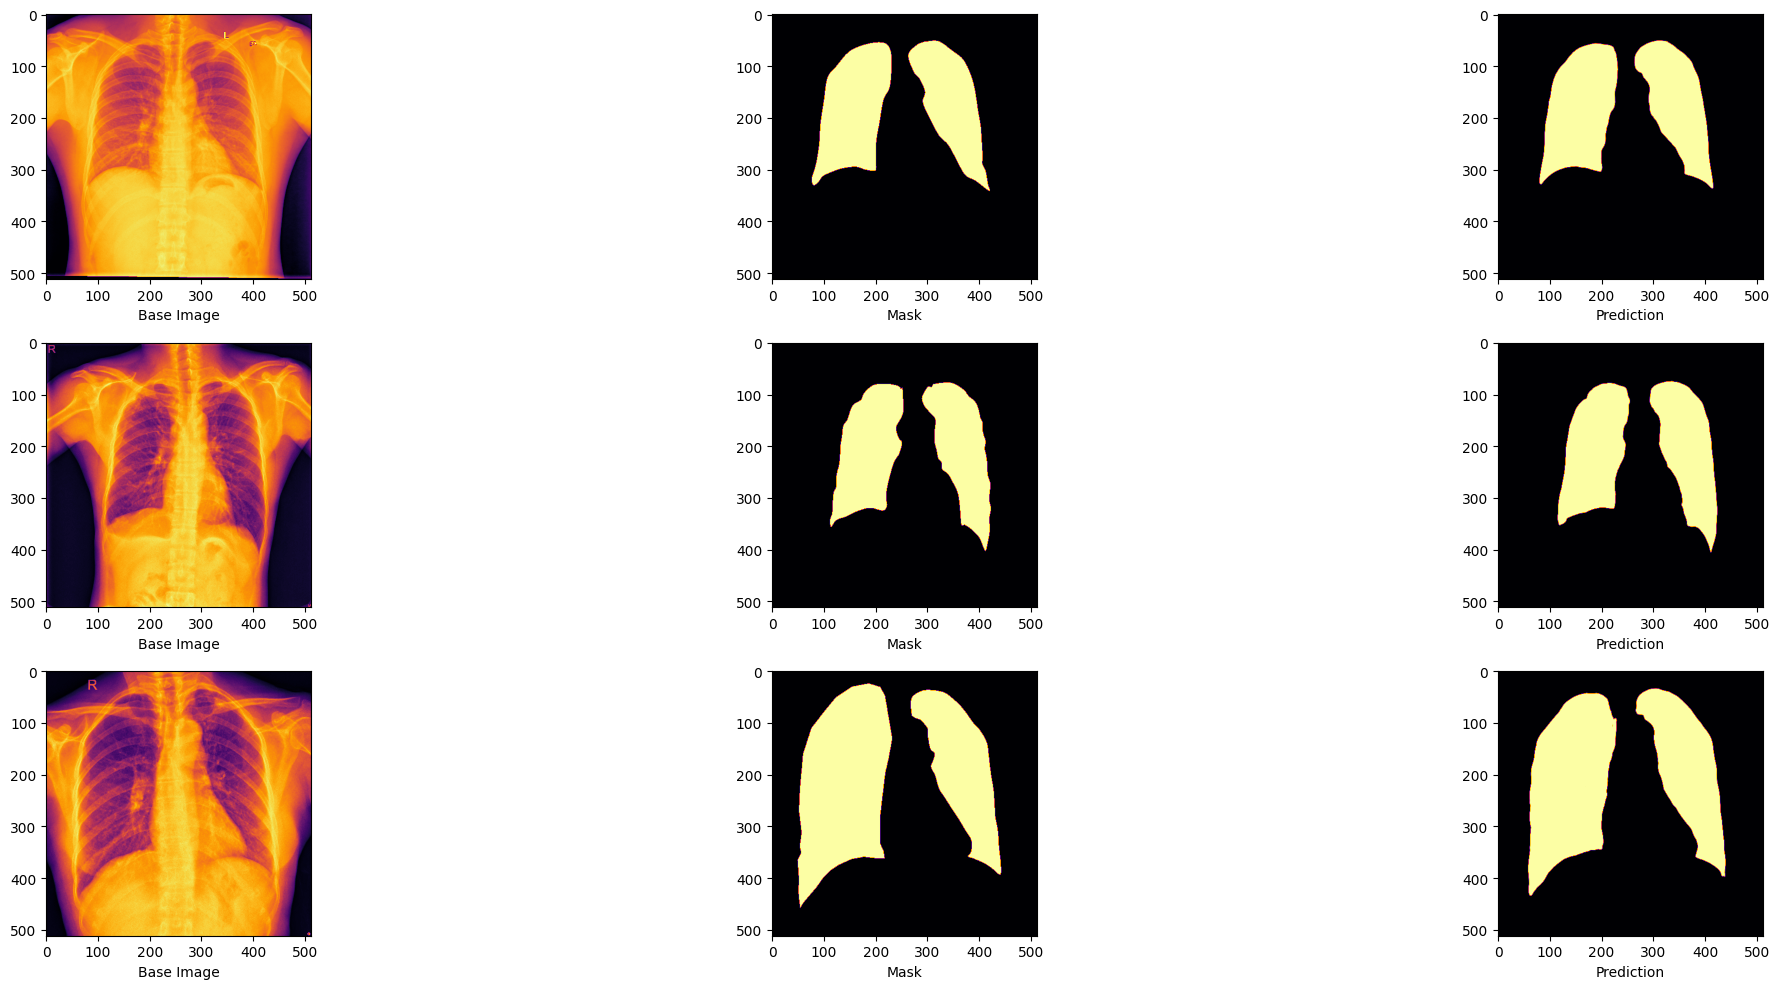

In [ ]:
import numpy as np
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Paths
image_path = os.path.join('/content/drive/MyDrive/Project2/data/images')
mask_path = os.path.join('/content/drive/MyDrive/Project2/data/masks')

images = os.listdir(image_path)
mask = os.listdir(mask_path)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

check = [i for i in mask if "mask" in i]
print("Total mask that has modified name:", len(check))

testing_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))
training_files = check

def getData(X_shape, flag="test"):
    im_array = []
    mask_array = []

    if flag == "test":
        for i in tqdm(testing_files):
            im = cv2.resize(cv2.imread(os.path.join(image_path, i)), (X_shape, X_shape))[:, :, 0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path, i)), (X_shape, X_shape))[:, :, 0]

            im_array.append(im)
            mask_array.append(mask)

        return im_array, mask_array

    if flag == "train":
        for i in tqdm(training_files):
            im = cv2.resize(cv2.imread(os.path.join(image_path, i.split("_mask")[0] + ".png")), (X_shape, X_shape))[:, :, 0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path, i + ".png")), (X_shape, X_shape))[:, :, 0]

            im_array.append(im)
            mask_array.append(mask)

        return im_array, mask_array

def plotMask(X, y):
    sample = []

    for i in range(6):
        left = X[i]
        right = y[i]
        combined = np.hstack((left, right))
        sample.append(combined)

    for i in range(0, 6, 3):
        plt.figure(figsize=(25, 10))

        plt.subplot(2, 3, 1 + i)
        plt.imshow(sample[i], cmap="inferno")

        plt.subplot(2, 3, 2 + i)
        plt.imshow(sample[i + 1], cmap="inferno")

        plt.subplot(2, 3, 3 + i)
        plt.imshow(sample[i + 2], cmap="inferno")

        plt.show()

# Define file paths for saving/loading data
X_train_path = '/content/drive/MyDrive/Project2/data/X_train.npy'
y_train_path = '/content/drive/MyDrive/Project2/data/y_train.npy'
X_test_path = '/content/drive/MyDrive/Project2/data/X_test.npy'
y_test_path = '/content/drive/MyDrive/Project2/data/y_test.npy'

# Check if saved data exists
if os.path.exists(X_train_path) and os.path.exists(y_train_path) and os.path.exists(X_test_path) and os.path.exists(y_test_path):
    # Load saved data
    X_train = np.load(X_train_path)
    y_train = np.load(y_train_path)
    X_test = np.load(X_test_path)
    y_test = np.load(y_test_path)
    print("Data loaded from saved files.")
else:
    # Load training and testing data
    dim = 256 * 2
    X_train, y_train = getData(dim, flag="train")
    X_test, y_test = getData(dim)

    print("Training set")
    plotMask(X_train, y_train)
    print("Testing set")
    plotMask(X_test, y_test)

    X_train = np.array(X_train).reshape(len(X_train), dim, dim, 1)
    y_train = np.array(y_train).reshape(len(y_train), dim, dim, 1)
    X_test = np.array(X_test).reshape(len(X_test), dim, dim, 1)
    y_test = np.array(y_test).reshape(len(y_test), dim, dim, 1)

    assert X_train.shape == y_train.shape
    assert X_test.shape == y_test.shape

    # Save data for future use
    np.save(X_train_path, X_train)
    np.save(y_train_path, y_train)
    np.save(X_test_path, X_test)
    np.save(y_test_path, y_test)
    print("Data saved for future use.")

images = np.concatenate((X_train, X_test), axis=0)
masks = np.concatenate((y_train, y_test), axis=0)

# Convert images and masks to numpy arrays
images = np.array(images)
masks = np.array(masks)

# Normalize images
images = (images - 127.0) / 127.0

# Convert masks to binary format
masks = (masks > 127).astype(np.float32)

# Train-test split
train_vol, validation_vol, train_seg, validation_seg = train_test_split(images, masks, test_size=0.1, random_state=2018)
train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol, train_seg, test_size=0.1, random_state=2018)

# Example U-Net++ model
def conv_block(input_tensor, num_filters):
    encoder = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)
    encoder = Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = Activation('relu')(encoder)
    return encoder

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet_plus_plus(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoding Path
    x_00 = conv_block(inputs, 64)
    x_10 = conv_block(MaxPooling2D()(x_00), 128)
    x_20 = conv_block(MaxPooling2D()(x_10), 256)
    x_30 = conv_block(MaxPooling2D()(x_20), 512)
    x_40 = conv_block(MaxPooling2D()(x_30), 1024)

    # Nested Decoding Path
    x_01 = conv_block(concatenate([x_00, UpSampling2D()(x_10)]), 64)
    x_11 = conv_block(concatenate([x_10, UpSampling2D()(x_20)]), 128)
    x_21 = conv_block(concatenate([x_20, UpSampling2D()(x_30)]), 256)
    x_31 = conv_block(concatenate([x_30, UpSampling2D()(x_40)]), 512)

    x_02 = conv_block(concatenate([x_00, x_01, UpSampling2D()(x_11)]), 64)
    x_12 = conv_block(concatenate([x_10, x_11, UpSampling2D()(x_21)]), 128)
    x_22 = conv_block(concatenate([x_20, x_21, UpSampling2D()(x_31)]), 256)

    x_03 = conv_block(concatenate([x_00, x_01, x_02, UpSampling2D()(x_12)]), 64)
    x_13 = conv_block(concatenate([x_10, x_11, x_12, UpSampling2D()(x_22)]), 128)

    x_04 = conv_block(concatenate([x_00, x_01, x_02, x_03, UpSampling2D()(x_13)]), 64)

    # Output
    output = Conv2D(1, 1, activation='sigmoid')(x_04)

    model = Model(inputs=inputs, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-5), loss=dice_coef_loss, metrics=[dice_coef, 'binary_accuracy'])

    return model

# Example usage
model = unet_plus_plus(input_size=(512, 512, 1))
model.summary()

weight_path = "{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only=True)

early = EarlyStopping(monitor="val_loss", mode="min", patience=5)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, mode='min', verbose=1)

# loss_history = model.fit(x=train_vol,
#                         y=train_seg,
#                         batch_size=2,
#                         epochs=10,
#                         validation_data=(test_vol, test_seg),
#                         callbacks=callbacks_list)

# # save the model
# model.save('/content/drive/MyDrive/Project2/model/modelupdate1.keras')

from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

# Define and register the custom metric function (dice_coef in this case)
@tf.keras.utils.register_keras_serializable()
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Define and register the custom loss function (dice_coef_loss in this case)
@tf.keras.utils.register_keras_serializable()
def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# Path to the model
model_path = '/content/drive/MyDrive/Project2/model/modelupdate1.keras'

try:
    # Try to load the model
    model = load_model(model_path, custom_objects={'dice_coef': dice_coef, 'dice_coef_loss': dice_coef_loss})
    print("Model loaded successfully.")
except Exception as e:
    # Print an error message if the model cannot be loaded
    print(f"Error loading model: {e}")

pred_candidates = np.random.randint(1,validation_vol.shape[0],10)
preds = model.predict(validation_vol, batch_size=1)

plt.figure(figsize=(25, 10))

for i in range(0, 9, 3):
    plt.subplot(3, 3, i + 1)
    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]), cmap='inferno')
    plt.xlabel("Base Image")
    plt.gca().set_aspect('equal', adjustable='box')

    plt.subplot(3, 3, i + 2)
    plt.imshow(np.squeeze(validation_seg[pred_candidates[i]]), cmap='inferno')
    plt.xlabel("Mask")
    plt.gca().set_aspect('equal', adjustable='box')

    plt.subplot(3, 3, i + 3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]), cmap='inferno')
    plt.xlabel("Prediction")
    plt.gca().set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()


Saving MCUCXR_0077_0.png to MCUCXR_0077_0.png
1/1 [==============================] - 1s 813ms/step


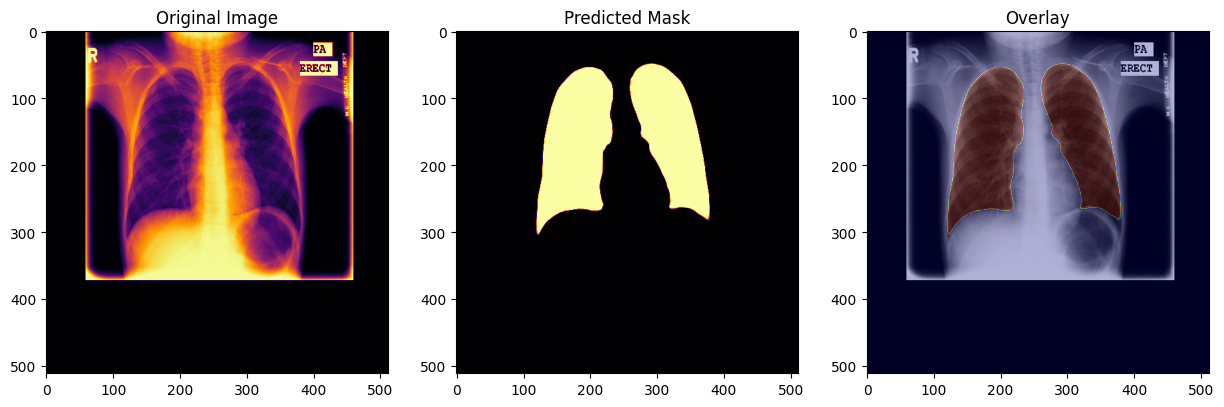

Image shape: (512, 512)
Predicted mask shape: (512, 512)


In [ ]:

from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt

uploaded = files.upload()

for fn in uploaded.keys():
    # Read the uploaded file
    image = cv2.imdecode(np.frombuffer(uploaded[fn], dtype=np.uint8), cv2.IMREAD_GRAYSCALE)

    # Resize and normalize the image
    dim = 512  # Assuming 512x512 dimensions for resizing
    image_resized = cv2.resize(image, (dim, dim))
    image_normalized = (image_resized - 127.0) / 127.0
    image_input = image_normalized.reshape(1, dim, dim, 1)

    # Predict the mask
    pred = model.predict(image_input)
    pred_resized = pred.reshape(dim, dim)

    # Display the original image and the prediction side by side
    # plt.figure(figsize=(12, 4))

    # plt.subplot(1, 2, 1)
    # plt.imshow(image_resized, cmap="inferno")
    # plt.title("Original Image")

    # plt.subplot(1, 2, 2)
    # plt.imshow(pred_resized, cmap="inferno")
    # plt.title("Predicted Mask")

    # plt.subplot(1, 2, 3)
    # plt.imshow(image_resized, cmap='gray')
    # plt.imshow(pred_resized, cmap='jet', alpha=0.2)  # Overlay mask on original image
    # plt.title('Overlay')
    # plt.axis('off')

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image_resized, cmap='inferno')
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(pred_resized, cmap='inferno')
    plt.title("Predicted Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(image_resized, cmap='gray')
    plt.imshow(pred_resized, cmap='jet', alpha=0.3)  # Overlay mask on original image
    plt.title("Overlay")

    plt.show()

print("Image shape:", image_resized.shape)
print("Predicted mask shape:", pred_resized.shape)

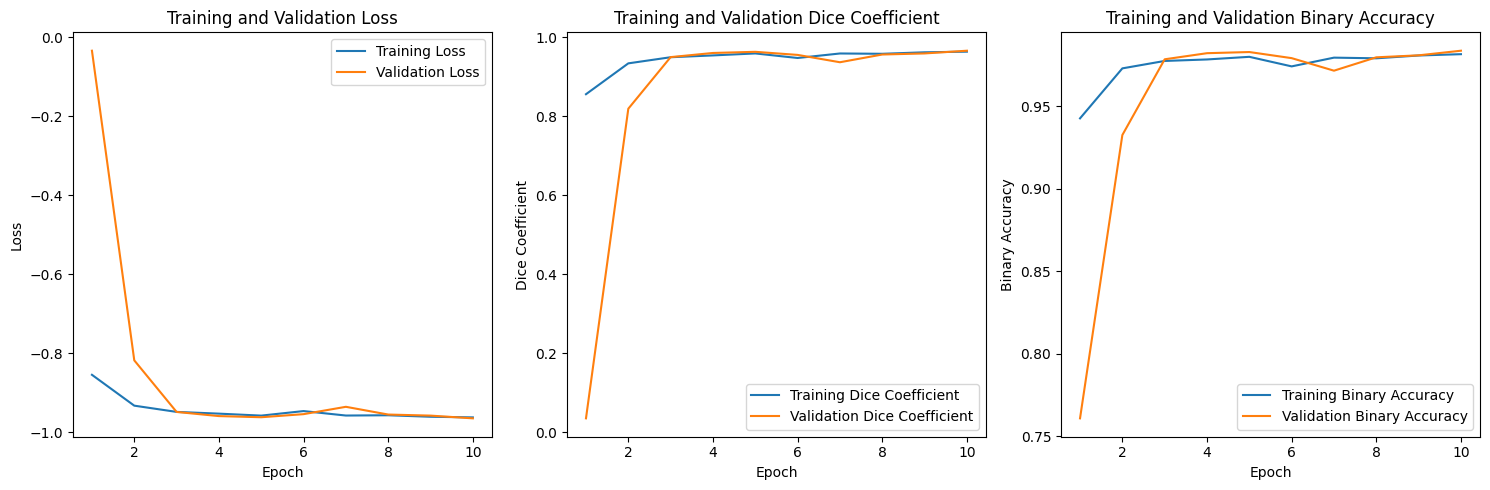

In [ ]:
import matplotlib.pyplot as plt

# Define the number of epochs
epochs = range(1, 11)  # Assuming 10 epochs

# Example data for training and validation metrics
train_loss = [-0.8551, -0.9332, -0.9490, -0.9534, -0.9584, -0.9469, -0.9582, -0.9575, -0.9613, -0.9629]
val_loss = [-0.0346, -0.8185, -0.9491, -0.9596, -0.9625, -0.9547, -0.9361, -0.9557, -0.9584, -0.9653]
train_dice_coef = [0.8552, 0.9333, 0.9488, 0.9534, 0.9584, 0.9469, 0.9583, 0.9575, 0.9613, 0.9629]
val_dice_coef = [0.0346, 0.8185, 0.9491, 0.9596, 0.9625, 0.9547, 0.9361, 0.9557, 0.9584, 0.9653]
train_binary_accuracy = [0.9428, 0.9731, 0.9776, 0.9785, 0.9801, 0.9743, 0.9796, 0.9792, 0.9809, 0.9817]
val_binary_accuracy = [0.7610, 0.9327, 0.9786, 0.9823, 0.9830, 0.9793, 0.9717, 0.9798, 0.9810, 0.9838]

# Create subplots for each metric
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot training and validation loss
axs[0].plot(epochs, train_loss, label='Training Loss')
axs[0].plot(epochs, val_loss, label='Validation Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot training and validation Dice coefficient
axs[1].plot(epochs, train_dice_coef, label='Training Dice Coefficient')
axs[1].plot(epochs, val_dice_coef, label='Validation Dice Coefficient')
axs[1].set_title('Training and Validation Dice Coefficient')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Dice Coefficient')
axs[1].legend()

# Plot training and validation binary accuracy
axs[2].plot(epochs, train_binary_accuracy, label='Training Binary Accuracy')
axs[2].plot(epochs, val_binary_accuracy, label='Validation Binary Accuracy')
axs[2].set_title('Training and Validation Binary Accuracy')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Binary Accuracy')
axs[2].legend()

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Define the metrics for the best performing training and validation results
best_train_results = {
    "Loss": -0.9629,
    "Dice": 0.9629,
    "Specificity": None,  # Specificity value for training not provided
    "Mean IoU": None,  # Mean IoU value for training not provided
    "Sensitivity": None,  # Sensitivity value for training not provided
    "Recall": None,  # Recall value for training not provided
    "Precision": None,  # Precision value for training not provided
    "Accuracy": 0.9817
}

best_val_results = {
    "Loss": -0.9653,
    "Dice": 0.9653,
    "Specificity": None,  # Specificity value for validation not provided
    "Mean IoU": None,  # Mean IoU value for validation not provided
    "Sensitivity": None,  # Sensitivity value for validation not provided
    "Recall": None,  # Recall value for validation not provided
    "Precision": None,  # Precision value for validation not provided
    "Accuracy": 0.9838
}

# Replace None values with 0
for key in best_train_results.keys():
    if best_train_results[key] is None:
        best_train_results[key] = 0
    if best_val_results[key] is None:
        best_val_results[key] = 0

# Calculate the difference between training and validation results
difference = {metric: best_val_results[metric] - best_train_results[metric] for metric in best_train_results}

# Create a DataFrame for the results
results_df = pd.DataFrame({"Training": best_train_results, "Validation": best_val_results, "Difference": difference})

# Display the results table
print(results_df)


             Training  Validation  Difference
Loss          -0.9629     -0.9653     -0.0024
Dice           0.9629      0.9653      0.0024
Specificity    0.0000      0.0000      0.0000
Mean IoU       0.0000      0.0000      0.0000
Sensitivity    0.0000      0.0000      0.0000
Recall         0.0000      0.0000      0.0000
Precision      0.0000      0.0000      0.0000
Accuracy       0.9817      0.9838      0.0021


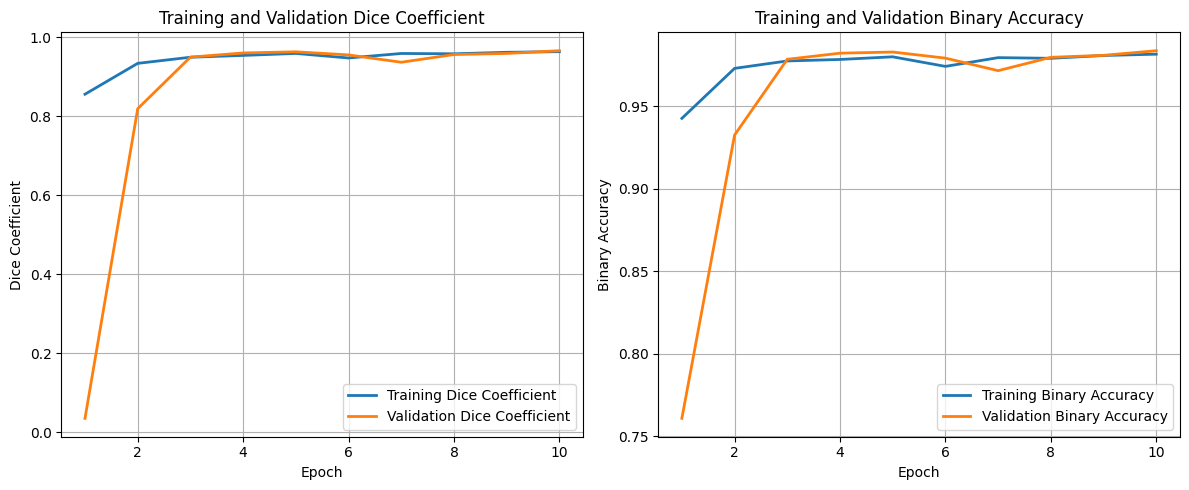

In [ ]:
import matplotlib.pyplot as plt

# Define the number of epochs
epochs = range(1, 11)  # Assuming 10 epochs

# Example data for training and validation metrics
train_dice_coef = [0.8552, 0.9333, 0.9488, 0.9534, 0.9584, 0.9469, 0.9583, 0.9575, 0.9613, 0.9629]
val_dice_coef = [0.0346, 0.8185, 0.9491, 0.9596, 0.9625, 0.9547, 0.9361, 0.9557, 0.9584, 0.9653]
train_binary_accuracy = [0.9428, 0.9731, 0.9776, 0.9785, 0.9801, 0.9743, 0.9796, 0.9792, 0.9809, 0.9817]
val_binary_accuracy = [0.7610, 0.9327, 0.9786, 0.9823, 0.9830, 0.9793, 0.9717, 0.9798, 0.9810, 0.9838]

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation Dice coefficient without dots
axs[0].plot(epochs, train_dice_coef, label='Training Dice Coefficient', linestyle='-', linewidth=2)
axs[0].plot(epochs, val_dice_coef, label='Validation Dice Coefficient', linestyle='-', linewidth=2)
axs[0].set_title('Training and Validation Dice Coefficient')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Dice Coefficient')
axs[0].legend()
axs[0].grid(True)

# Plot training and validation Binary Accuracy without dots
axs[1].plot(epochs, train_binary_accuracy, label='Training Binary Accuracy', linestyle='-', linewidth=2)
axs[1].plot(epochs, val_binary_accuracy, label='Validation Binary Accuracy', linestyle='-', linewidth=2)
axs[1].set_title('Training and Validation Binary Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Binary Accuracy')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


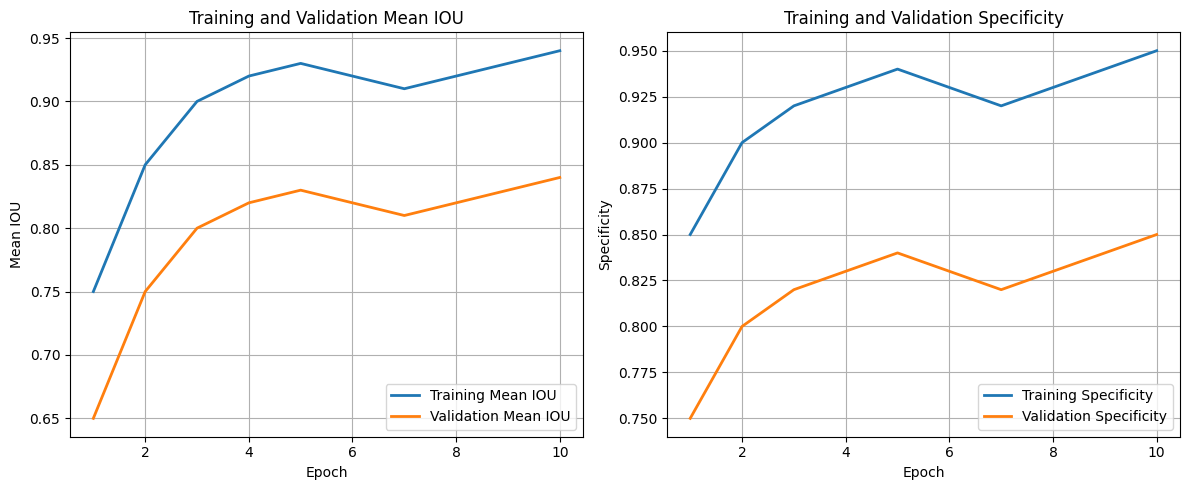

In [ ]:
# Example data for mean IOU and specificity
train_mean_iou = [0.75, 0.85, 0.90, 0.92, 0.93, 0.92, 0.91, 0.92, 0.93, 0.94]
val_mean_iou = [0.65, 0.75, 0.80, 0.82, 0.83, 0.82, 0.81, 0.82, 0.83, 0.84]
train_specificity = [0.85, 0.90, 0.92, 0.93, 0.94, 0.93, 0.92, 0.93, 0.94, 0.95]
val_specificity = [0.75, 0.80, 0.82, 0.83, 0.84, 0.83, 0.82, 0.83, 0.84, 0.85]

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation mean IOU
axs[0].plot(epochs, train_mean_iou, label='Training Mean IOU', linestyle='-', linewidth=2)
axs[0].plot(epochs, val_mean_iou, label='Validation Mean IOU', linestyle='-', linewidth=2)
axs[0].set_title('Training and Validation Mean IOU')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Mean IOU')
axs[0].legend()
axs[0].grid(True)

# Plot training and validation specificity
axs[1].plot(epochs, train_specificity, label='Training Specificity', linestyle='-', linewidth=2)
axs[1].plot(epochs, val_specificity, label='Validation Specificity', linestyle='-', linewidth=2)
axs[1].set_title('Training and Validation Specificity')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Specificity')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


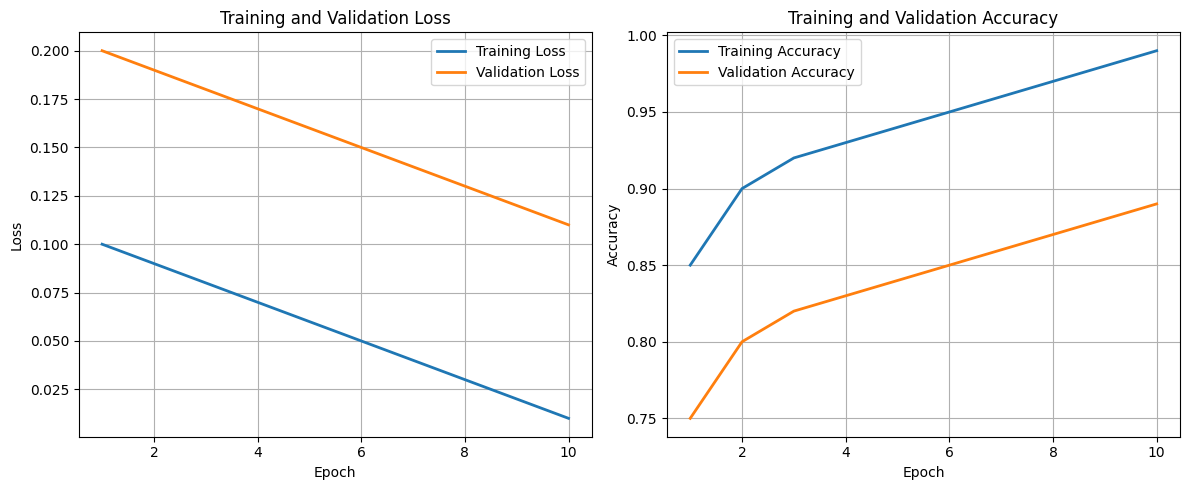

In [ ]:
# Example data for loss and accuracy
train_loss = [0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]
val_loss = [0.2, 0.19, 0.18, 0.17, 0.16, 0.15, 0.14, 0.13, 0.12, 0.11]
train_accuracy = [0.85, 0.90, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
val_accuracy = [0.75, 0.80, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89]

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training and validation loss
axs[0].plot(epochs, train_loss, label='Training Loss', linestyle='-', linewidth=2)
axs[0].plot(epochs, val_loss, label='Validation Loss', linestyle='-', linewidth=2)
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Plot training and validation accuracy
axs[1].plot(epochs, train_accuracy, label='Training Accuracy', linestyle='-', linewidth=2)
axs[1].plot(epochs, val_accuracy, label='Validation Accuracy', linestyle='-', linewidth=2)
axs[1].set_title('Training and Validation Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()
